# Visualising Social Metrics

This notebook generates all the proxemic figures used in 
[our paper](https://doi.org/10.1145/3411764.3445729) on _Proxemics and Social 
Interactions in an Instrumented Virtual Reality Workshop_. 

## Using this Notebook, Code, or Data
This notebook and all of the resources included here are released on a 
[Mozilla Public License 2.0](https://www.mozilla.org/en-US/MPL/2.0/).  The data 
is released under [CC-BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).
To cite the paper, the bespoke logging client, the dataset, or this notebook 
please see the [README.md](https://github.com/ayman/hubs-research-2021/blob/main/README.md) 
or the [DOI in the ACM Digital Library](https://doi.org/10.1145/3411764.3445729).

## Requirements

In [1]:
import pickle
import pandas as pd
import numpy as np
import scipy
from scipy import  spatial
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

Load our past pickles and csv data.

In [2]:
with open("outputs/social_metrics.pkl", "rb") as f:
    loaded_matrices = pickle.load(f)
    
main_room = pd.read_csv('outputs/main_room_resampled_0.167.csv')
a_room = pd.read_csv('outputs/room_a_resampled_0.167.csv')
b_room = pd.read_csv('outputs/room_b_resampled_0.167.csv')
c_room = pd.read_csv('outputs/room_c_resampled_0.167.csv')

## Generating Visualisations

Generating visualisations from Hubs positional logs also requires
using Mozilla Spoke to provide context to the coordinate system.  The
coordinates returned by the logger are based on the coordinates of the
room design, and can be checked by open the room assets in Spoke.

For our visualisations, we use a rotated view of the room layout, which
results in some confusing naming schemes here as the X and Z axis are 
rotated. Y, which represents height within the Hubs coordinate system, 
is unchanged.  The assets for Outdoor Meetup and Lake Office top down 
views where taken directly from Spoke.

In [3]:
def draw_kde_map(df,
                 bins=50,
                 pct=1,
                 save_fig="outputs/default.png",
                 grid="assets/Outdoor Meetup.png", 
                 x_min=60,
                 x_max=-10,
                 y_min=20,
                 y_max=-20,
                 quiver=False, 
                 quiver_overlay=None):
    """draw_kde_map takes in a data frame and draws a kernal density
    estimate figure for the data frame.  The default values will
    produce kde maps for the outdoor meetup room.

    """
    plt.figure()
    meetup = plt.imread(grid)
    df_clean = df.dropna()

    # For all visualisations, X and Y refer to 2D x and y axis.  This
    # mapping is different than default Hubs coordinate system

    # Note that rotated view means Hubs X coord is Y for 2d
    # visualisation and that rotated view means Hubs Z coord is X for
    # 2d visualisation
    ys = df_clean['position_x'].values
    xs = df_clean['position_z'].values

    plt.gca().set_facecolor("#09061F")
    
    plt.yscale('linear')
    plt.xscale('linear')
    # Take these coords from the limit of your grid in Spoke
    plt.ylim((y_min, y_max)) 
    plt.xlim((x_min, x_max))
    
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    ax = sns.kdeplot(x=xs, y=ys, cmap=plt.cm.inferno, shade=True) 
    
    plt.imshow(meetup, extent=[x_min, x_max, y_min, y_max], zorder=3)
    
    # Quiver overlay needs to be calculated separately, and rotated if needed.
    if quiver:
        overlay = plt.imread(quiver_overlay)
        plt.imshow(overlay,extent=[x_min, x_max, y_min, y_max], zorder=5)
   
    plt.savefig(save_fig, format='pdf', bbox_inches="tight", dpi=1200) 
    plt.show()

### Figure 4

This histogram shows the probability distribution of the nearest participant
(euclidean distance in meters) in the Keynote Session compared to
Breakout Room A. The proxemic zones (see Hall's 1969 paper) and labelled 
across the X axis.  In the small group discussions in Breakout Room A,
participants stood closer. There was a greater probability of standing with 
others in the personal and social distances as compared to the Keynote session.
Collisions in the intimate distance occurred infrequently in both sessions 
and participants adjusted their social spacing when intimate distances
occurred.

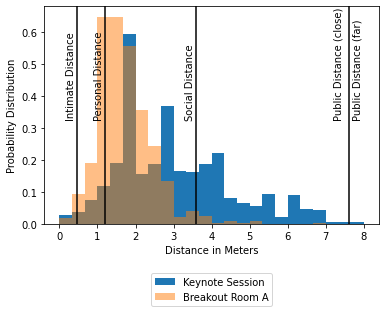

In [4]:
ks = loaded_matrices["keynote"]["mins_by_frame"][~np.isnan(loaded_matrices["keynote"]["mins_by_frame"])].flatten()
aas = loaded_matrices["a_room"]["mins_by_frame"][~np.isnan(loaded_matrices["a_room"]["mins_by_frame"])].flatten()

plt.figure()
bins = np.linspace(0, 8.0, 25)
n1, bins, patches = plt.hist(ks, 
                             bins=bins, 
                             density=True, 
                             # color="#F6E61F",
                             label="Keynote Session")
n2, bins, patches = plt.hist(aas, 
                             bins=bins, 
                             alpha=0.5, 
                             density=True, 
                             # color="#4BC26C",
                             label="Breakout Room A") 
plt.xlabel("Distance in Meters")
plt.ylabel("Probability Distribution")
plt.axvline(x=.46,  c='black')
plt.axvline(x=1.2, c='black')
plt.axvline(x=3.6 , c='black')
plt.axvline(x=7.6 , c='black')
plt.text(.16, .33, "Intimate Distance", rotation=90)
plt.text(.9, .33, "Personal Distance", rotation=90)
plt.text(3.3, .33, "Social Distance", rotation=90)
plt.text(7.2, .33, "Public Distance (close)", rotation=90)
plt.text(7.7, .33, "Public Distance (far)", rotation=90)

lgd = plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))

plt.savefig('outputs/figure_4_closest_person.pdf',
            bbox_extra_artists=(lgd,),
            bbox_inches='tight',
            format='pdf',
            dpi=1200)

### Figure 5

Position data overview for the duration of the workshop in the Outdoor Meetup
space. Activity took place most often in the centre of the room, but the 
floor decals in the space were an unexpected deterrent. Participants also 
avoided the large amphitheatre and no activities made specific use of this 
feature.

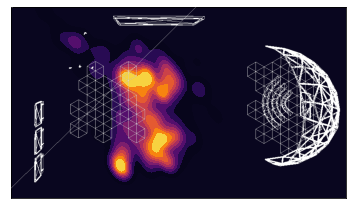

In [5]:
draw_kde_map(main_room, save_fig="outputs/overall.pdf")

## Quiver Plot

The quiver plot adds a visualisation of field of view to the KDE plots. 

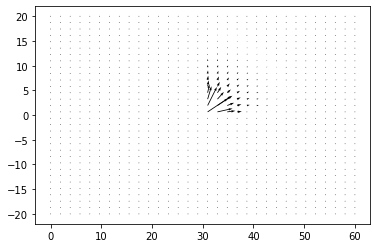

In [6]:
# Takes one person (row) and returns a flow field
def falloff_function(x, y, z, grid, dist=1.0, exp=2.0):
    # distance falloff only
    vx = grid[0] - x
    vz = grid[1] - z
    return 1.0/(np.sqrt((vx**2 + vz**2)/dist)**exp+1)

def angular_cone(x,y,z,dx,dy,dz,grid,fov=80):
    vx = grid[0] - x
    vz = grid[1] - z
    vnorm = np.linalg.norm(np.stack([vx, vz]), axis=0)
    vx = vx/vnorm
    vz = vz/vnorm
    dnorm = np.sqrt(dx**2 + dz**2)
    dx_norm = dx / dnorm
    dz_norm = dz / dnorm
    grid_angle = np.arctan2(vx, vz)
    angular_difference = grid_angle - np.arctan2(dx_norm, dz_norm)
    angular_difference = np.minimum((2 * np.pi) - np.abs(angular_difference),
                                    np.abs(angular_difference))
    
    cone = np.where(abs(angular_difference)>np.radians(fov/2), 0, 1)
    return (vx*cone, vz*cone)

resolution = 32
# sets the range for the grid
mx, mz = np.meshgrid(np.linspace(0, 60, resolution), np.linspace(-20, 20, resolution))

falloff = falloff_function(30, 0.0, 0.0, (mx, mz), dist=7.6)

# Helper function demonstrates/tests the quiver plot for a single person.
plt.figure()
dot_product = angular_cone(30, 0.0, 0.0, 0.7, 0.0, 0.7, (mx, mz), fov=80) 
plt.quiver(mx, mz, dot_product[0] * falloff, dot_product[1] * falloff, scale=10)

In [7]:
def frame_field(frame, grid, falloff_distance=50, fov=80):
    accumulator = np.zeros_like(grid[0]), np.zeros_like(grid[1])
    for ix, uuid in frame.iterrows():
        flow = person_flow_field(uuid.position_x, 
                                 uuid.position_y, 
                                 uuid.position_z, 
                                 uuid.direction_x, 
                                 uuid.direction_y,
                                 uuid.direction_z,
                                 grid, 
                                 falloff_distance, 
                                 fov)
        
        accumulator[0][:] += flow[0]
        accumulator[1][:] += flow[1]
    # average flow for one frame
    return accumulator[0] / len(frame), accumulator[1] / len(frame)

# Takes a sequence of frames and returns an average flow field
def frame_sequence_field(df,
                         resolution,
                         x_min,
                         x_max,
                         z_min,
                         z_max,
                         falloff_distance=50,
                         fov=80):
    # sets the range for the grid
    mx, mz = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(z_min, z_max, resolution))
    grid = (mx, mz)
    accumulator = np.zeros_like(grid[0]), np.zeros_like(grid[1])
    n_frames = 0
    for frame_id, frame in df.groupby("frame_id"):
        # print(f"Frame {n_frames} {frame_id}")
        flow = frame_field(frame, grid, falloff_distance, fov)
        n_frames += 1
        accumulator[0][:] += flow[0]
        accumulator[1][:] += flow[1]
    # average flow for one frame
    return (grid[0], 
            grid[1], 
            accumulator[0] / n_frames, 
            accumulator[1] / n_frames)

In [8]:
def person_flow_field(x, y, z, 
                      dx, dy, dz, 
                      grid, falloff_distance=50, fov=80):
    falloff = falloff_function(x, y, z, grid, dist=falloff_distance)
    cone = angular_cone(x, y, z, dx, dy, dz, grid, fov=fov) 
    return falloff * cone

# flow = person_flow_field(30.0, 0.0, 0.0, 1.0, 0.0, 0.0, (mx, mz), fov=80)
# plt.figure()
# plt.quiver(mx, mz, flow[0], flow[1], scale=10)
# # One frame and returns an average flow field

In [9]:
# Calculate all values needed to generate quiverplot for the entire
# keynote slice.
x, z, u, v = frame_sequence_field(loaded_matrices["keynote"]["slice"],
                                  32, -20, 20, -10, 60,
                                  falloff_distance=7.6,
                                  fov=80)

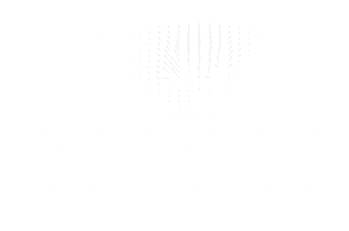

In [10]:
fig, ax = plt.subplots()
plt.quiver(z, x,  v, u, scale=1.5, color="#f0f2f1")
plt.axis("equal")

ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis("off")

fig.savefig('outputs/quiver_overlay.png', 
            format='png', 
            bbox_inches="tight", 
            dpi=1200, 
            transparent=True)

img = Image.open("outputs/quiver_overlay.png")
r_img = img.rotate(180, expand=True)
r_img.save("outputs/quiver_overlay.png")
# Note: This figure is very light because we will overlay it in the
# Figure 6 step.

### Figure 6

Heatmap of the Outdoor Meetup space during the Keynote Session overlaid 
with a quiver plot visualisation participants' field of view.

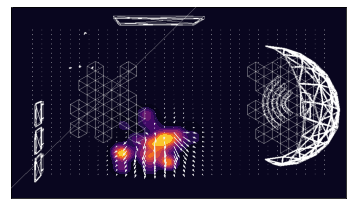

In [11]:
draw_kde_map(loaded_matrices["keynote"]["slice"], 
             save_fig="outputs/figure_6_keynote_quiver.pdf", 
             quiver=True, 
             quiver_overlay="outputs/quiver_overlay.png")

### Figure 7

Histogram of z-axis in Outdoor Meetup during the keynote and the second 
break. With Fly-mode enabled, participants could use the vertical space 
to gain a better view, but during breaks participants were more likely 
to constrain themselves to the floor plane.

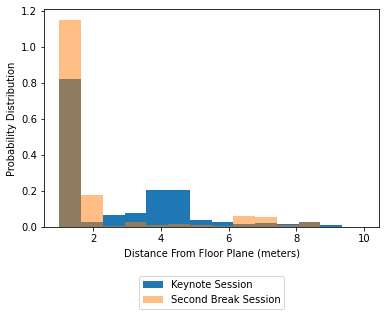

In [12]:
k_ys = loaded_matrices["keynote"]["slice"].position_y
b_ys = loaded_matrices["break_2"]["slice"].position_y

plt.figure()
bins = np.linspace(1, 10, 15)
plt.hist(k_ys,
         bins=bins,
         density=True,
         label="Keynote Session")
plt.hist(b_ys,
         bins=bins,
         alpha=0.5,
         density=True,
         # color="#4BC26C",
         label="Second Break Session")

plt.xlabel("Distance From Floor Plane (meters)")
plt.ylabel("Probability Distribution")
lgd = plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
plt.savefig('outputs/figure_7_offTheFloor.pdf',
            bbox_extra_artists=(lgd,),
            bbox_inches='tight',
            format='pdf',
            dpi=1200)

### Figure 8

Heatmaps of the Outdoor Meetup space during scheduled breaks show where
participants formed groups. During the first break, there was only one 
large group.  During the second group, small groups surrounded a large 
group.

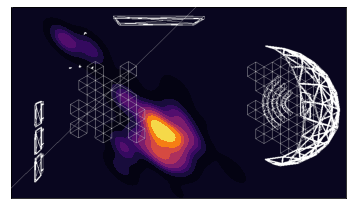

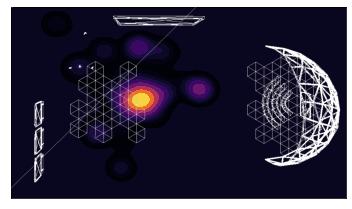

In [13]:
draw_kde_map(loaded_matrices["break_1"]["slice"],
             save_fig="outputs/figure_8_break1.pdf")
draw_kde_map(loaded_matrices["break_2"]["slice"],
             save_fig="outputs/figure_8_break2.pdf")

### Other Visualisations

Although we didn't include any visualisations from the break rooms in the 
paper, this code demonstrates how to generate this visualisations with 
the correct settings.

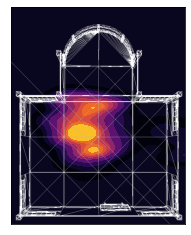

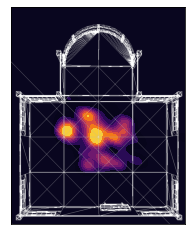

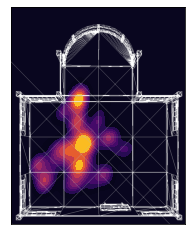

In [14]:
draw_kde_map(a_room, grid="assets/Lake Office.png", 
             x_min=10, x_max=-10, y_min=10, y_max=-15)
draw_kde_map(b_room, grid="assets/Lake Office.png", 
             x_min=10, x_max=-10, y_min=10, y_max=-15)
draw_kde_map(c_room, grid="assets/Lake Office.png", 
             x_min=10, x_max=-10, y_min=10, y_max=-15)

Next visit the <a href="4.Animate.ipynb">Animate</a> notebook.